# 用户购买预测baseline
$\color{red}{Tips：该部分主要为介绍思路和基线修改指南，实战部分在后半部分单独列出}$
## 赛题介绍
智能营销工具可以帮助商家预测用户购买的行为，本次比赛提供了一份品牌商家的历史订单数据，参赛选手需构建一个预测模型，预估用户人群在规定时间内产生购买行为的概率。
该模型可应用于各种电商数据分析，以及百度电商开放平台， 不仅可以帮助商家基于平台流量，进行商品售卖、支付，还可以通过MarTech技术更精准地锁定核心用户，对用户的购买行为进行预测。

- $\color{red}{特别注意：数据进行了模拟生成，对某些特征含义进行了隐藏，并进行了脱敏处理}$

- $\color{red}{特别注意：本次比赛需要选手使用飞桨PaddlePaddle1.7以及以上版本参赛}$

[点击跳转至赛题页面](https://aistudio.baidu.com/aistudio/competition/detail/51)

## 基线介绍
### 运行方式

本次基线基于飞桨PaddlePaddle1.8版本，若本地运行则可能需要额外安装jupyter notebook环境、pandas模块等。
AI Studio上运行建议使用32G内存的高级版，本地运行同样建议配置较大的内存空间。

#### AI Studio (Notebook)运行

依次运行下方的cell即可，若运行时修改了cell，推荐在右上角重启执行器后再以此运行，避免因内存未清空而产生报错。

#### 本地运行

fork本项目后点击右上角的“文件”——“导出Notebook为ipynb”，下载到本地后在`jupyter notebook`环境即可开始训练，生成的推理结果文件为`submission.csv`。

### 设计思想

#### 执行流程

1. 配置预处理数据方案(选手可以自行设计，默认提供用于时间滑窗特征工程和归一化两种方案)
2. 检查数据是否可以正确读取（可省略，若选手自行修改了数据预处理部分，务必检查能否读取后再进行下一步操作）
3. 开始训练
4. 执行预测并产生结果文件

#### 技术方案
在本次赛题中，虽然赛题是一个二分类任务（用户购买、未购买），但从赛题数据看，属于比较典型的时间序列数据，也可以参照以往的线性回归任务的做法处理。 
接下来将介绍技术方案中的一些细节问题以及method流程。

##### label设计
本次赛题反映了一个客观事实——在真实场景应用机器学习/深度学习技术时，通常是没有已经整理好的训练集、验证集、测试集，需要自己设计。

比如赛题中提到，在比赛任务是预测下个月用户是否购买，下个月是哪个月？我们不妨设想自己是个业务经理，现在领导说做个模型，预测下个月你手上的客户是否会流失。所以在这类题目中，下个月就是提供的数据集截止日期之后的一个月。当然，如果比赛要求预测未来7天、未来15天的销售情况，道理也是一样的。

在此类比赛的解决方案中，通常会有个时间滑窗的概念。比如按月进行时间滑窗，本题中数据到2013.8.31，默认提供的数据集划分设计如下（选手也可以自行设计数据集的划分）：
- 训练集：用2013年4-6月的数据预测用户在7月是否购买
- 验证集：用2013年5-7月的数据预测用户在8月是否购买
- 测试集：用2013年6-8月的数据预测用户在9月是否购买（其实就是预测的目标）

```python
# 这是一个时间滑窗函数，获得dt之前minus天以来periods的dataframe，以便进一步计算
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]
```

##### 时间滑窗特征构建
> 注：更详细的时间滑窗特征工程的方法请参考[用户购买预测时间滑窗特征构建](https://aistudio.baidu.com/aistudio/projectdetail/276829)，本项目做了大幅缩减。

时间滑窗在业务应用上被称为RFM模型，RFM模型最早是用来衡量客户价值和客户创利能力。理解RFM框架的思想是构造统计类特征的基础，其含义为：
- R（Recency）：客户最近一次交易消费时间的间隔。R值越大，表示客户交易发生的日期越久，反之则表示客户交易发生的日期越近。
- F（Frequency）：客户在最近一段时间内交易消费的次数。F值越大，表示客户交易越频繁，反之则表示客户交易不够活跃。
- M（Monetary）：客户在最近一段时间内交易消费的金额。M值越大，表示客户价值越高，反之则表示客户价值越低。

也就是说，时间滑窗特征本身是与业务紧密联系的，而在这类时间序列数据的比赛中，滑动时间窗口内的统计指标可以更加丰富，统计值一般会有最大值、最小值、均值、标准差、中位数、极差等。

```python
# 要计算统计指标特征的时间窗口
for i in [14,30,60,91]:
	tmp = get_timespan(df_payment, t2018, i, i)
   # 削去峰值的均值特征
   X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
   # 中位数特征，在本赛题中基本不适用
   # X['median_%s' % i] = tmp.median(axis=1).values
   # 最小值特征，在本赛题中基本不适用
   # X['min_%s' % i] = tmp_1.min(axis=1).values
   # 最大值特征
   X['max_%s' % i] = tmp.max(axis=1).values
   # 标准差特征
   # X['std_%s' % i] = tmp_1.std(axis=1).values
   # 求和特征
   X['sum_%s' % i] = tmp.sum(axis=1).values
```
##### 深度学习模型搭建
参考[使用飞桨重写房价预测模型](https://aistudio.baidu.com/aistudio/projectdetail/366426)和[Martech_track1_beta](https://aistudio.baidu.com/aistudio/projectdetail/510779)搭建三层深度神经网络。需要注意的是，由于神经网络对缺失值和稀疏数据敏感，对送入神经网络的特征需要做筛选。另外，选择哪种神经网络结构效果更好，需要参赛选手进一步探索。
```python
# 构建多层神经网络
class Regressor(fluid.dygraph.Layer):
    def __init__(self, name_scope):
        super(Regressor, self).__init__(name_scope)
        name_scope = self.full_name()
        # 定义三层全连接层，输入维度是最终选取的特征数量，输出维度是1，激活函数为relu
        self.fc1 = Linear(input_dim=41, output_dim=128, act='relu') # 输入层，input dim 为数据维度大小
        self.fc2 = Linear(input_dim=128, output_dim=128, act='relu')
        self.fc3 = Linear(input_dim=128, output_dim=1, act='sigmoid')
    # 网络的前向计算函数
    def forward(self, inputs):
        fc1 = self.fc1(inputs)
        fc2 = self.fc2(fc1)
        x = self.fc3(fc2)
        return x
```

## 数据预处理 - 数据集划分与特征工程

In [1]:
import numpy as np  #
import pandas as pd  #
from datetime import datetime, date, timedelta
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
# from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV,Ridge,Lasso,ElasticNet
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,RandomForestClassifier
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.svm import SVR, LinearSVC
# from sklearn.pipeline import make_pipeline,Pipeline
# from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler,MinMaxScaler
# from sklearn.model_selection import KFold, cross_val_score, train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
from itertools import product
import datetime as dt
import calendar
import gc
from datetime import date, timedelta
import paddle
# import paddle.fluid as fluid
# import paddle.fluid.dygraph as dygraph
# from paddle.fluid.dygraph import Linear
import random

/Users/lorenzlorentz/anaconda/anaconda3/envs/dm/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


### 加载数据集

In [3]:
PATH = 'Data/'
train = pd.read_csv(PATH + 'train.csv')
# train = pd.read_csv('./data/data19383/train.csv', usecols=[2, 3, 4, 6, 7, 18])
# set index to ID to avoid droping it later
# 把测试集的id列作为索引，防止误删
test  = pd.read_csv(PATH + 'submission.csv').set_index('customer_id')

In [4]:
# 训练集概况
train[['order_detail_id','order_id','order_amount','order_pay_time','is_customer_rate','order_detail_goods_num','order_detail_amount','order_detail_discount','customer_id','goods_id']].tail(10)

,order_detail_id,order_id,order_amount,order_pay_time,is_customer_rate,order_detail_goods_num,order_detail_amount,order_detail_discount,customer_id,goods_id
2306861,3685490,3238357,707.7,2013-01-24 00:24:40,0.0,2.0,179.8,298.2,2826572,1478
2306862,3685491,3238356,775.9,2012-11-11 17:35:05,0.0,1.0,126.9,172.1,2826572,2103
2306863,3685492,3238357,707.7,2013-01-24 00:24:40,0.0,1.0,0.0,29.9,2826572,3153
2306864,3685493,3238356,775.9,2012-11-11 17:35:05,0.0,1.0,74.9,105.0,2826572,1778
2306865,3685494,3238357,707.7,2013-01-24 00:24:40,0.0,1.0,94.9,104.9,2826572,2128
2306866,3685495,3238358,199.0,2013-01-10 19:24:31,0.0,1.0,59.9,139.1,2826573,1173
2306867,3685496,3238359,299.8,2013-01-27 15:00:27,0.0,1.0,0.0,59.9,2826574,2513
2306868,3685497,3238359,299.8,2013-01-27 15:00:27,0.0,1.0,89.9,150.0,2826574,998
2306869,3685498,3238360,168.0,2012-11-11 00:10:37,0.0,1.0,76.9,91.1,2826574,1423
2306870,3685499,3238361,102.0,2013-07-10 14:22:14,0.0,1.0,49.9,52.1,2826574,1043


In [5]:
len(test)

1585986

In [6]:
len(train['customer_id'][train.order_pay_time>'2013-07-31'].unique())

174770

In [7]:
len(train[train.order_pay_time<'2013-07-31'])

2078390

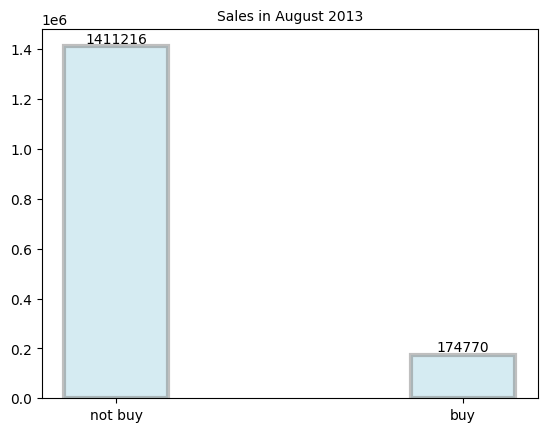

In [8]:
%matplotlib inline
y = range(1,2)
 
plt.bar(['not buy','buy'], [1585986-174770,174770], alpha=0.5, width=0.3, color='lightblue', edgecolor='grey', lw=3)
plt.title('Sales in August 2013', fontsize=10)
for a, b in zip(['not buy','buy'], [1585986-174770,174770]):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
plt.show()

In [9]:
# 对于特别大的文件，我们需要做一些内存检查
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(mem_train/ 1024**2)+" MB")
print(u"测试集使用内存 "+ str(mem_test/ 1024**2)+" MB")

训练集使用内容 510.40096282958984 MB
测试集使用内存 24.200225830078125 MB


### 内存优化脚本
- 参考[缓解pandas中DataFrame占用内存过大的问题](https://blog.csdn.net/wj1066/article/details/81124959)
- 效果非常显著，有效避免内存溢出

In [10]:
# @from: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65/code
# @liscense: Apache 2.0
# @author: weijian
def reduce_mem_usage(props):
    # 计算当前内存
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage of the dataframe is :", start_mem_usg, "MB")
    
    # 哪些列包含空值，空值用-999填充。why：因为np.nan当做float处理
    NAlist = []
    for col in props.columns:
        # 这里只过滤了objectd格式，如果你的代码中还包含其他类型，请一并过滤
        if (props[col].dtypes != object):
            
            # print("**************************")
            # print("columns: ", col)
            # print("dtype before", props[col].dtype)
            
            # 判断是否是int类型
            isInt = False
            mmax = props[col].max()
            mmin = props[col].min()
            
            # Integer does not support NA, therefore Na needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(-999, inplace=True) # 用-999填充
                
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = np.fabs(props[col] - asint)
            result = result.sum()
            if result < 0.01: # 绝对误差和小于0.01认为可以转换的，要根据task修改
                isInt = True
            
            # make interger / unsigned Integer datatypes
            if isInt:
                if mmin >= 0: # 最小值大于0，转换成无符号整型
                    if mmax <= 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mmax <= 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mmax <= 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else: # 转换成有符号整型
                    if mmin > np.iinfo(np.int8).min and mmax < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mmin > np.iinfo(np.int16).min and mmax < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mmin > np.iinfo(np.int32).min and mmax < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mmin > np.iinfo(np.int64).min and mmax < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)  
            else: # 注意：这里对于float都转换成float16，需要根据你的情况自己更改
                props[col] = props[col].astype(np.float16)
            
            # print("dtype after", props[col].dtype)
            # print("********************************")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [11]:
# 处理id字段
train['order_detail_id'] = train['order_detail_id'].astype(np.uint32)
train['order_id'] = train['order_id'].astype(np.uint32)
train['customer_id'] = train['customer_id'].astype(np.uint32)
train['goods_id'] = train['goods_id'].astype(np.uint32)
train['goods_class_id'] = train['goods_class_id'].astype(np.uint32)
train['member_id'] = train['member_id'].astype(np.uint32)
# 处理状态字段，这里同时处理空值，将空值置为0
train['order_status'] = train['order_status'].astype(np.uint8)
train['goods_has_discount'] = train['goods_has_discount'].astype(np.uint8)
train["is_member_actived"].fillna(0, inplace=True)
train["is_member_actived"]=train["is_member_actived"].astype(np.int8)
train["member_status"].fillna(0, inplace=True)
train["member_status"]=train["member_status"].astype(np.int8)
train["customer_gender"].fillna(0, inplace=True)
train["customer_gender"]=train["customer_gender"].astype(np.int8)
train['is_customer_rate'] = train['is_customer_rate'].astype(np.uint8)
train['order_detail_status'] = train['order_detail_status'].astype(np.uint8)
# 处理日期
train['goods_list_time']=pd.to_datetime(train['goods_list_time'],format="%Y-%m-%d")
train['order_pay_time']=pd.to_datetime(train['order_pay_time'],format="%Y-%m-%d")
train['goods_delist_time']=pd.to_datetime(train['goods_delist_time'],format="%Y-%m-%d")
# 检查内存使用
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(mem_train/ 1024**2)+" MB")
print(u"测试集使用内存 "+ str(mem_test/ 1024**2)+" MB")

/var/folders/3c/722zgt1n5r9gk4bm3s2v64_80000gn/T/ipykernel_4620/1606167042.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["is_member_actived"].fillna(0, inplace=True)
/var/folders/3c/722zgt1n5r9gk4bm3s2v64_80000gn/T/ipykernel_4620/1606167042.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

ValueError: unconverted data remains when parsing with format "%Y-%m-%d": " 11:08:07", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [1]:
# train['customer_city_id'] = LabelEncoder().fit_transform(train['customer_city'].astype(str))
# train['customer_province_id'] = LabelEncoder().fit_transform(train['customer_province'].astype(str))

### 构造时间滑窗特征

#### 每日付款金额

In [12]:
# 将用户下单金额按天进行汇总
# df = train[train.order_status<101][train.order_pay_time>'2013-02-01']
df = train[train.order_pay_time>'2013-02-01']
df['date'] = pd.DatetimeIndex(df['order_pay_time']).date
df_payment = df[['customer_id','date','order_total_payment']]

/var/folders/3c/722zgt1n5r9gk4bm3s2v64_80000gn/T/ipykernel_4620/4022739742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.DatetimeIndex(df['order_pay_time']).date


In [13]:
len(df_payment['customer_id'].unique())

685471

注意，成功交易的客户数量不等于全部客户数量，说明有相当一部分客户虽然下过单，但是没有成功的订单，那么这些客户自然应当算在训练集之外。
数据合并时，由于`test.csv`中，已经设置了默认0值，只需要和训练后的预测标签做一个`left join`就可以了

In [ ]:
df_payment = df_payment.groupby(['date','customer_id']).agg({'order_total_payment': ['sum']})
df_payment.columns = ['day_total_payment']
df_payment.reset_index(inplace=True)

In [ ]:
df_payment = df_payment.set_index(
    ["customer_id", "date"])[["day_total_payment"]].unstack(level=-1).fillna(0)
df_payment.columns = df_payment.columns.get_level_values(1)

#### 每日购买商品数量

In [ ]:
df_goods = df[['customer_id','date','order_total_num']]
df_goods = df_goods.groupby(['date','customer_id']).agg({'order_total_num': ['sum']})
df_goods.columns = ['day_total_num']
df_goods.reset_index(inplace=True)
df_goods = df_goods.set_index(
    ["customer_id", "date"])[["day_total_num"]].unstack(level=-1).fillna(0)
df_goods.columns = df_goods.columns.get_level_values(1)

该场景每天都有成交记录，这样就不需要考虑生成完整时间段填充的问题

In [ ]:
# 这是一个时间滑窗函数，获得dt之前minus天以来periods的dataframe，以便进一步计算
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

1. 构造dataset这里有个取巧的地方，因为要预测的9月份除了开学季以外不是非常特殊的月份，因此主要考虑近期的因素，数据集的开始时间也是2月1日，尽量避免了双十一、元旦假期的影响，当然春节假期继续保留。同时，构造数据集的时候保留了customer_id，主要为了与其它特征做整合。
2. 通过一个函数整合付款金额和商品数量的时间滑窗，主要是因为分开做到时候合并占用内存更大，并且函数最后在返回值处做了内存优化，用时间代价尽可能避免内存溢出。

In [ ]:
def prepare_dataset(df_payment, df_goods, t2018, is_train=True):
    X = {}
    # 整合用户id
    tmp = df_payment.reset_index()
    X['customer_id'] = tmp['customer_id']
    # 消费特征
    print('Preparing payment feature...')
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        # X['diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s' % i] = tmp_1.mean(axis=1).values
        # X['median_%s' % i] = tmp.median(axis=1).values
        # X['min_%s' % i] = tmp_1.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        # X['std_%s' % i] = tmp_1.std(axis=1).values
        X['sum_%s' % i] = tmp.sum(axis=1).values
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018 + timedelta(days=-7), i, i)
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s_2' % i] = tmp_2.mean(axis=1).values
        # X['median_%s_2' % i] = tmp.median(axis=1).values
        # X['min_%s_2' % i] = tmp_2.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        # X['std_%s_2' % i] = tmp_2.std(axis=1).values
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        X['has_sales_days_in_last_%s' % i] = (tmp != 0).sum(axis=1).values
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp != 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_last_%s' % i] = ((tmp != 0) * np.arange(i, 0, -1)).max(axis=1).values

    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['day_%s_2018' % i] = get_timespan(df_payment, t2018, i*30, 30).sum(axis=1).values
    # 商品数量特征，这里故意把时间和消费特征错开，提高时间滑窗的覆盖面
    print('Preparing num feature...')
    for i in [21,49,84]:
            tmp = get_timespan(df_goods, t2018, i, i)
            # X['goods_diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
            # X['goods_mean_%s_decay' % i] = (tmp_1 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
            X['goods_mean_%s' % i] = tmp.mean(axis=1).values
            # X['goods_median_%s' % i] = tmp.median(axis=1).values
            # X['goods_min_%s' % i] = tmp_1.min(axis=1).values
            X['goods_max_%s' % i] = tmp.max(axis=1).values
            # X['goods_std_%s' % i] = tmp_1.std(axis=1).values
            X['goods_sum_%s' % i] = tmp.sum(axis=1).values
    for i in [21,49,84]:    
            tmp = get_timespan(df_goods, t2018 + timedelta(weeks=-1), i, i)
            # X['goods_diff_%s_mean_2' % i] = tmp_2.diff(axis=1).mean(axis=1).values
            # X['goods_mean_%s_decay_2' % i] = (tmp_2 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
            X['goods_mean_%s_2' % i] = tmp.mean(axis=1).values
            # X['goods_median_%s_2' % i] = tmp.median(axis=1).values
            # X['goods_min_%s_2' % i] = tmp_2.min(axis=1).values
            X['goods_max_%s_2' % i] = tmp.max(axis=1).values
            X['goods_sum_%s_2' % i] = tmp.sum(axis=1).values
    for i in [21,49,84]:    
            tmp = get_timespan(df_goods, t2018, i, i)
            X['goods_has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
            X['goods_last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
            X['goods_first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values


    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['goods_day_%s_2018' % i] = get_timespan(df_goods, t2018, i*28, 28).sum(axis=1).values

    X = pd.DataFrame(X)
    
    reduce_mem_usage(X)
    
    if is_train:
        # 这样转换之后，打标签直接用numpy切片就可以了
        # 当然这里前提是确认付款总额没有负数的问题
        X['label'] = df_goods[pd.date_range(t2018, periods=30)].max(axis=1).values
        X['label'][X['label'] > 0] = 1
        return X
    return X

In [2]:
num_days = 4
t2017 = date(2013, 7, 1)
X_l, y_l = [], []
for i in range(num_days):
    delta = timedelta(days=7 * i)
    # X_tmp, y_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = pd.concat([X_tmp], axis=1)

    X_l.append(X_tmp)
    # y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
# y_train = np.concatenate(y_l, axis=0)

del X_l, y_l

In [ ]:
X_test = prepare_dataset(df_payment, df_goods, date(2013, 9, 1), is_train=False)
X_test = pd.concat([X_test], axis=1)

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 345.16217041015625 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.86999416351318  MB
This is  21.40153252476465 % of the initial size


### 中间结果保存

In [ ]:
X_train.to_csv('X_train.csv')

In [ ]:
X_test.to_csv('X_test.csv')

## 训练&推理 - 训练配置以及训练
### 加载特征工程结果

In [ ]:
# X_train = pd.read_csv('X_train.csv',usecols=['max_30','has_sales_days_in_last_30','first_has_sales_day_in_last_60','goods_sum_49','label'])
X_train = pd.read_csv('X_train.csv')
X_train.drop(['Unnamed: 0','customer_id'], inplace=True, axis=1)

In [ ]:
X_val = pd.read_csv('X_val.csv')
X_val.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
X_test = pd.read_csv('X_test.csv')
# X_test = pd.read_csv('X_test.csv',usecols=['max_30','has_sales_days_in_last_30','first_has_sales_day_in_last_60','goods_sum_49'])
X_test.drop(['Unnamed: 0','customer_id'], inplace=True, axis=1)

In [ ]:
X_train.head()

,mean_14_decay,max_14,sum_14,mean_30_decay,max_30,sum_30,mean_60_decay,max_60,sum_60,mean_91_decay,...,goods_has_sales_days_in_last_49,goods_last_has_sales_day_in_last_49,goods_first_has_sales_day_in_last_49,goods_has_sales_days_in_last_84,goods_last_has_sales_day_in_last_84,goods_first_has_sales_day_in_last_84,goods_day_1_2018,goods_day_2_2018,goods_day_3_2018,label
0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,0.0
1,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,0.0
2,0.0,0.0,0.0,3.537,39.9,39.9,3.537,39.9,39.9,3.537,...,1,24,24,1,24,24,1,0,0,0.0
3,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,1.0
4,0.0,0.0,0.0,0.000,0.0,0.0,2.530,98.9,197.8,2.530,...,1,37,37,2,37,56,0,2,0,1.0


### 选取参与训练的特征

In [ ]:
print(X_train.columns)

Index(['mean_14_decay', 'max_14', 'sum_14', 'mean_30_decay', 'max_30',
       'sum_30', 'mean_60_decay', 'max_60', 'sum_60', 'mean_91_decay',
       'max_91', 'sum_91', 'mean_14_decay_2', 'max_14_2', 'mean_30_decay_2',
       'max_30_2', 'mean_60_decay_2', 'max_60_2', 'mean_91_decay_2',
       'max_91_2', 'has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91',
       'first_has_sales_day_in_last_91', 'day_1_2018', 'day_2_2018',
       'day_3_2018', 'goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21

In [ ]:
X_train = X_train[['has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91','goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21_2', 'goods_mean_49_2', 'goods_max_49_2', 'goods_sum_49_2',
       'goods_mean_84_2', 'goods_max_84_2', 'goods_sum_84_2',
       'goods_has_sales_days_in_last_21',
       'goods_last_has_sales_day_in_last_21',
       'goods_first_has_sales_day_in_last_21',
       'goods_has_sales_days_in_last_49',
       'goods_last_has_sales_day_in_last_49',
       'goods_first_has_sales_day_in_last_49',
       'goods_has_sales_days_in_last_84',
       'goods_last_has_sales_day_in_last_84',
       'goods_first_has_sales_day_in_last_84', 'goods_day_1_2018',
       'goods_day_2_2018', 'goods_day_3_2018','label']]
X_test = X_test[['has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91','goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21_2', 'goods_mean_49_2', 'goods_max_49_2', 'goods_sum_49_2',
       'goods_mean_84_2', 'goods_max_84_2', 'goods_sum_84_2',
       'goods_has_sales_days_in_last_21',
       'goods_last_has_sales_day_in_last_21',
       'goods_first_has_sales_day_in_last_21',
       'goods_has_sales_days_in_last_49',
       'goods_last_has_sales_day_in_last_49',
       'goods_first_has_sales_day_in_last_49',
       'goods_has_sales_days_in_last_84',
       'goods_last_has_sales_day_in_last_84',
       'goods_first_has_sales_day_in_last_84', 'goods_day_1_2018',
       'goods_day_2_2018', 'goods_day_3_2018']]

In [ ]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

### 数据归一化

In [ ]:
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [ ]:
# 前面标签也被归一化了，还原
X_train['label'][X_train['label'] > 0] = 1

In [ ]:
print(len(X_train.columns))

42


In [ ]:
# 数据分割
def load_data(df,istrain):
    # data = np.fromfile(datafile)
    data = df

    feature_num = len(data.columns)
    # 将原始数据进行Reshape
    data = np.array(data)
    data = data.reshape([-1, feature_num])
    
    # 训练集和测试集的划分比例
    #ratio = 0.8
    if istrain == True:
        ratio = 0.8
        offset = int(data.shape[0] * ratio)
        training_data = data[:offset]
        test_data = data[offset:]
    else:
        training_data = data
        test_data = None

    return training_data, test_data

In [ ]:
# 加载处理后的数据
training_data, test_data = load_data(X_train,True)
print('train set done.')

pre_data, none = load_data(X_test,False)
print('test set done.')

train set done.
test set done.


### 搭建多层神经网络

In [ ]:
# 构建多层神经网络
class Regressor(fluid.dygraph.Layer):
    def __init__(self, name_scope):
        super(Regressor, self).__init__(name_scope)
        name_scope = self.full_name()
        # 定义三层全连接层，输出维度是1，激活函数为relu
        self.fc1 = Linear(input_dim=41, output_dim=128, act='relu') # 输入层，input dim 为数据维度大小
        self.fc2 = Linear(input_dim=128, output_dim=128, act='relu')
        self.fc3 = Linear(input_dim=128, output_dim=1, act='sigmoid')
    # 网络的前向计算函数
    def forward(self, inputs):
        fc1 = self.fc1(inputs)
        fc2 = self.fc2(fc1)
        x = self.fc3(fc2)
        return x

In [ ]:
with fluid.dygraph.guard():
    # 声明定义好的线性回归模型
    model = Regressor("Regressor")
    # 开启模型训练模式
    model.train()
    # 定义优化算法，这里使用Adam Optimizer
    # 学习率设置为0.00001
    opt = fluid.optimizer.Adam(learning_rate=0.00001, parameter_list=model.parameters())

### 定义损失函数

In [ ]:
# 使用类别权重对数据不平衡问题进行处理
def wce_loss(pred, label, w=48, epsilon=1e-05): # w 是给到 y=1 类别的权重，越大越重视
    label = fluid.layers.clip(label, epsilon, 1-epsilon)
    pred = fluid.layers.clip(pred, epsilon, 1-epsilon)

    loss = -1 * (w * label * fluid.layers.log(pred) + (1 - label) * fluid.layers.log(1 - pred))
    loss = fluid.layers.reduce_mean(loss)
    return loss

### 开始训练

In [ ]:
# 模型训练和保存
with dygraph.guard(fluid.CPUPlace()):
    EPOCH_NUM = 10   # 设置外层循环次数
    BATCH_SIZE = 4096  # 设置batch大小
    
    # 定义外层循环
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(training_data)
        # 将训练数据进行拆分
        mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
        
        # 定义内层循环
        for iter_id, mini_batch in enumerate(mini_batches):
            x = np.array(mini_batch[:, :-1]).astype('float32') # 获得当前批次训练数据
            y = np.array(mini_batch[:, -1:]).astype('float32') # 获得当前批次训练标签

            # 将numpy数据转为飞桨动态图variable形式
            buyer_features = dygraph.to_variable(x)
            result = dygraph.to_variable(y)
            
            # 前向计算
            predicts = model(buyer_features)
            # loss = fluid.layers.log_loss(predicts, prices)
            loss = wce_loss(predicts, result)
            avg_loss = fluid.layers.mean(loss)
            
            # logloss = fluid.layers.log_loss(predicts, prices)

            if iter_id % 20 == 0:
                print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.numpy()))
                # print(predicts)
     
            # 反向传播
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.minimize(avg_loss)
            # 清除梯度
            model.clear_gradients()
    # 保存模型
    fluid.save_dygraph(model.state_dict(), 'MLP_model')
    print("模型保存成功，模型参数保存在MLP_model中")

epoch: 0, iter: 0, loss is: [6.4240947]
epoch: 0, iter: 20, loss is: [5.585197]
epoch: 0, iter: 40, loss is: [5.9884305]
epoch: 0, iter: 60, loss is: [5.601056]
epoch: 0, iter: 80, loss is: [5.5771275]
epoch: 0, iter: 100, loss is: [5.566127]
epoch: 0, iter: 120, loss is: [5.829499]
epoch: 0, iter: 140, loss is: [5.45304]
epoch: 0, iter: 160, loss is: [5.3009186]
epoch: 0, iter: 180, loss is: [4.9718328]
epoch: 0, iter: 200, loss is: [5.0031395]
epoch: 0, iter: 220, loss is: [4.9489536]
epoch: 0, iter: 240, loss is: [4.632763]
epoch: 0, iter: 260, loss is: [4.880851]
epoch: 0, iter: 280, loss is: [4.8238106]
epoch: 0, iter: 300, loss is: [4.730828]
epoch: 0, iter: 320, loss is: [4.7572412]
epoch: 0, iter: 340, loss is: [4.4746714]
epoch: 0, iter: 360, loss is: [4.5569715]
epoch: 0, iter: 380, loss is: [4.664049]
epoch: 0, iter: 400, loss is: [4.577633]
epoch: 0, iter: 420, loss is: [4.354995]
epoch: 0, iter: 440, loss is: [4.148847]
epoch: 0, iter: 460, loss is: [4.207163]
epoch: 0, it

### 生成提交文件

In [ ]:
with dygraph.guard():
    # 参数为保存模型参数的文件地址
    model_dict, _ = fluid.load_dygraph('MLP_model')
    model.load_dict(model_dict)
    model.eval()
    pre = pre_data.astype('float32')
    # 将数据转为动态图的variable格式
    pre = dygraph.to_variable(pre)
    results = model(pre)

    print("Inference result is {}".format(results.numpy()[:5]))

Inference result is [[0.65414643]
 [0.9220496 ]
 [0.9159751 ]
 [0.51936257]
 [0.55256414]]


In [ ]:
print(len(results))

685471


In [ ]:
results.numpy().flatten()[:6]

array([0.65414643, 0.9220496 , 0.9159751 , 0.51936257, 0.55256414,
       0.9197315 ], dtype=float32)

In [ ]:
sub = pd.read_csv('X_test.csv', usecols=['customer_id'])

In [ ]:
df_preds = pd.DataFrame(
{    "customer_id": sub.customer_id, 
    "pred": results.numpy().flatten()}
)

In [ ]:
df_preds.head()

,customer_id,pred
0,1000014,0.654146
1,1000034,0.922050
2,1000046,0.915975
3,1000069,0.519363
4,1000105,0.552564


In [ ]:
sub = pd.read_csv('data/data19383/submission.csv')

In [ ]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1585986 entries, 0 to 1585985
Data columns (total 2 columns):
customer_id    1585986 non-null int64
result         1585986 non-null float64
dtypes: float64(1), int64(1)
memory usage: 24.2 MB


In [ ]:
submission = pd.merge(sub, df_preds, on='customer_id', how='left')
submission.fillna(0,inplace=True)
submission = submission[['customer_id','pred']]
submission.rename(columns={'customer_id':'customer_id','pred':'result'}, inplace=True)

In [ ]:
submission.head()

,customer_id,result
0,1000000,0.000000
1,1000014,0.654146
2,1000034,0.922050
3,1000046,0.915975
4,1000048,0.000000


In [ ]:
# 将概率值转换为用户是否购买的标签
def f(x):
    if x <= 0.5:
        return 0
    if x > 0.5:
        return 1
    return x

In [ ]:
submission['result'] = submission['result'].map(f)

In [ ]:
submission.to_csv('submission.csv',index=False)

## 写在最后

### 可选优化方案

> 本次比赛可调优空间非常大，可尝试且不限于从以下方面来进行调优，如果尝试后发现效果并不理想，可以在基线项目的评论区中和大家一起讨论~

**数据处理**

> 1. 归一化方案 - 直接拉伸是最佳方式吗？
> 2. 离散值与连续值 - 哪种方式更适合处理这些方式？是否有较为通用的方法可以尝试？是否可以使用Embedding？
> 3. 特征工程 - 除了时间滑窗是否可以有其它特征？有没有不使用特征工程的解决方案？
> 4. 特征选择 - 输入特征真的是越多越好吗？如何选择特征以克服神经网络训练的不稳定性？
> 5. 数据集划分比例 - 训练集、验证集、测试集应该怎样划分效果更好？

**首层网络选择**

> 1. Embedding还是Linear、Conv？- 如果使用卷积应该怎样处理shape？
> 2. 多字段合并输入还是分开输入？- 分开输入效果一定好吗？哪些字段更适合合并输入？

**网络(Backbone)部分搭建**

> 1. 隐层大小选择 - 宽度和层数
> 2. 尝试复杂网络构建 - 是否可以尝试简单CNN、RNN？如何使用飞桨复现经典解决方案？是否可以尝试使用图神经网络？如何使用PGL构建本赛题的异构图？
> 3. 选择更合适的激活函数
> 4. 尝试正则化、dropout等方式避免过拟合
> 5. 尝试非Xavier初始化方案

**模型(Model)搭建以及训练相关**

> 1. 选择学习率等超参数
> 2. 选择合适的损失函数 - 如何处理数据不平衡问题？
> 3. 尝试不同的优化器
> 4. 尝试使用学习率调度器
> 5. 避免脏数据干扰(用深度学习的方式更优更方便)

**模型融合**

> 1. 深度学习模型自身是否需要进行模型融合？模型融合是否能克服神经网络训练的不稳定性？
> 2. 是否能使用不同深度学习模型进行融合？

**提交相关**

> 1. 测试集表现最好的模型一定是最优秀的吗？
> 2. 用准确率来衡量二分类模型的能力是最好选择吗？

### 参考资料

- 用户购买预测练习赛总结
  - [用户购买预测练习赛：数据集探索分析（EDA）](https://aistudio.baidu.com/aistudio/projectdetail/438644)

      - 介绍时间序列数据常见的探索思路在AI Studio上的实现

  - [用户购买预测练习赛：时间滑窗特征构建](https://aistudio.baidu.com/aistudio/projectdetail/276829)

      - 介绍时间序列数据上时间滑窗的特征的生成与内存优化策略

  - [用户购买预测练习赛：用户和产品特征构建](https://aistudio.baidu.com/aistudio/projectdetail/438772)

      - 介绍基本推荐算法的特征工程在比赛数据集上的实现

  - [用户购买预测练习赛：月销量预测实现](https://aistudio.baidu.com/aistudio/projectdetail/438793)

      - 另一种时间滑窗思路，按月预测销量，属于分支探索
- [连锁超市销量预估案例](https://www.kaggle.com/c/favorita-grocery-sales-forecasting)
  - [数据集已上传到AI Studio平台](https://aistudio.baidu.com/aistudio/datasetdetail/17815)
  - [第一名解决方案](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/discussion/47582)
  - [第五名解决方案](https://github.com/LenzDu/Kaggle-Competition-Favorita)
- [月销量预测案例](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)
- [一套系统的特征工程框架](https://github.com/dayeren/Kaggle_Competition_Treasure/tree/master/Recommendations/Instacart)

## 代码审查

如选手成绩靠前并收到官方邮件通知代码审查，请参考该[链接](https://aistudio.baidu.com/aistudio/projectdetail/743661)进行项目上传操作  
快捷命令:`!zip -rP [此处添加审查邮件中的Key值] [邮件中的UID值].zip /home/aistudio/`